In [42]:
!pip install --user -r requirements.txt

In [58]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

In [78]:
training_folder = "../../shared_data/training_mini"

In [79]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 

100	 Dateien wurden geladen.


In [61]:
idx_record = 80
print("IDs[0:3]: ",ids[:3])
print("Verfügbare Kanäle:",channels[idx_record])
print("Abtastrate: ", sampling_frequencies[idx_record],"Hz")
print("Referenzsystem: ", reference_systems[idx_record])
print("EEG Labels: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaaqvr_s001_t001', 'aaaaaqvr_s002_t000', 'aaaaaqvr_s002_t001']
Verfügbare Kanäle: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate:  256 Hz
Referenzsystem:  AR
EEG Labels: (seizure_present, onset, offset) (0, 0.0, 0.0)


In [62]:
print("Anzahl der Aufnahmen:", len(ids))
print("Beispiel-IDs:", ids[:3])
print("Beispiel-Kanäle für eine Aufnahme:", channels[0])
print("Beispiel-Abtastrate:", sampling_frequencies[0])
print("Beispiel-Referenzsystem:", reference_systems[0])
print("Beispiel-EEG Label:", eeg_labels[0])


Anzahl der Aufnahmen: 1018
Beispiel-IDs: ['aaaaaqvr_s001_t001', 'aaaaaqvr_s002_t000', 'aaaaaqvr_s002_t001']
Beispiel-Kanäle für eine Aufnahme: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Beispiel-Abtastrate: 256
Beispiel-Referenzsystem: AR
Beispiel-EEG Label: (0, 0.0, 0.0)


In [63]:
idx_record = 0 # oder ein anderer Index Ihrer Wahl
print("Kanäle für Aufnahme", idx_record, ":", channels[idx_record])
print("Abtastrate für Aufnahme", idx_record, ":", sampling_frequencies[idx_record], "Hz")
print("EEG-Daten-Dimension für Aufnahme", idx_record, ":", data[idx_record].shape)


Kanäle für Aufnahme 0 : ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate für Aufnahme 0 : 256 Hz
EEG-Daten-Dimension für Aufnahme 0 : (19, 323328)


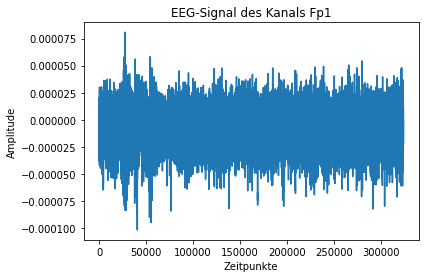

In [64]:
import matplotlib.pyplot as plt

plt.plot(data[idx_record][0, :]) # Erster Kanal der gewählten Aufnahme
plt.title(f"EEG-Signal des Kanals {channels[idx_record][0]}")
plt.xlabel("Zeitpunkte")
plt.ylabel("Amplitude")
plt.show()


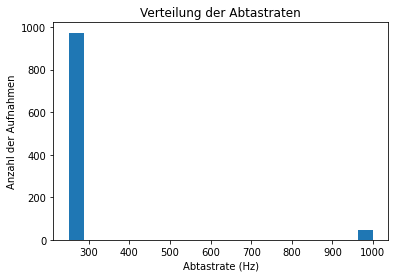

In [65]:
plt.hist(sampling_frequencies, bins=20)
plt.title("Verteilung der Abtastraten")
plt.xlabel("Abtastrate (Hz)")
plt.ylabel("Anzahl der Aufnahmen")
plt.show()


In [66]:
missing_data = any(d is None for d in data)
print("Fehlende Daten vorhanden:", missing_data)


Fehlende Daten vorhanden: False


In [67]:
seizures_present = [label[0] for label in eeg_labels]
print("Anzahl der Aufnahmen mit Anfällen:", sum(seizures_present))


Anzahl der Aufnahmen mit Anfällen: 407


In [68]:
print("Datentyp von 'data':", type(data))
print("Struktur der EEG-Daten:", type(data[0]))


Datentyp von 'data': <class 'list'>
Struktur der EEG-Daten: <class 'numpy.ndarray'>


In [69]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Angenommen, Sie haben Ihre Daten bereits geladen:
# ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder)

# Konvertieren der EEG-Daten in das erforderliche Format
def prepare_data(data, channels, time_steps=400):
    num_records = len(data)
    formatted_data = np.empty((num_records, 3, time_steps)) # [Anzahl der Beispiele, 3 Kanäle, Zeitpunkte]

    for i in range(num_records):
        montages, montage_data, _ = get_3montages(channels[i], data[i])
        montage_data_resized = montage_data[:, :time_steps] if montage_data.shape[1] > time_steps else np.pad(montage_data, ((0,0), (0, time_steps - montage_data.shape[1])), 'constant')
        formatted_data[i] = montage_data_resized

    return formatted_data

# Vorbereiten der Daten
formatted_data = prepare_data(data, channels)

# Überprüfen der Dimensionen der formatierten Daten
print("Dimensionen der formatierten Daten:", formatted_data.shape)

# Stellen Sie sicher, dass die Dimensionen [num_records, 3, time_steps] sind
expected_shape = (len(data), 3, 400)  # 400 ist ein Beispiel für time_steps
if formatted_data.shape == expected_shape:
    print("Die Daten haben das erwartete Format.")
else:
    print(f"Unerwartetes Format. Erwartet: {expected_shape}, Erhalten: {formatted_data.shape}")

Dimensionen der formatierten Daten: (1018, 3, 400)
Die Daten haben das erwartete Format.


In [70]:
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, num_channels=3, time_steps=400):
        super(EEGNet, self).__init__()
        # 1D Convolutional Layer
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Max Pooling Layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # Anpassen der Feature-Map-Größe nach Pooling
        reduced_size = time_steps // 4  # angenommen, zweimaliges Pooling halbiert die Größe jedes Mal
        self.fc1 = nn.Linear(64 * reduced_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten der Ausgabe für die Linear Layers
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = EEGNet(num_channels=3, time_steps=400)
print(model)


EEGNet(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

best_f1 = 0.0  # Initialisieren Sie den besten F1-Score mit 0
best_model = None  # Variable zum Speichern des besten Modells

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validierung und Berechnung des F1-Scores
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = outputs.squeeze().round()
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    epoch_f1 = f1_score(all_labels, all_predictions)
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_model = model.state_dict()  # Speichern des besten Modells

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, F1-Score: {epoch_f1:.4f}')

# Laden des besten Modells nach dem Training
model.load_state_dict(best_model)


Epoch 1/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 2/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 3/20, Loss: 0.7034, F1-Score: 0.5714
Epoch 4/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 5/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 6/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 7/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 8/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 9/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 10/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 11/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 12/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 13/20, Loss: 0.7007, F1-Score: 0.5714
Epoch 14/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 15/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 16/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 17/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 18/20, Loss: 0.6996, F1-Score: 0.5714
Epoch 19/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 20/20, Loss: 0.7023, F1-Score: 0.5714


<All keys matched successfully>

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

best_f1 = 0.0
best_model = model.state_dict()  # Initialisierung mit dem Anfangszustand des Modells

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Stellen Sie sicher, dass beide eindimensional sind
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validierung und Berechnung des F1-Scores
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = outputs.squeeze().round()  # Squeeze und Round für binäre Klassifikation
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.squeeze().tolist())  # Stellen Sie sicher, dass die Labels eindimensional sind

    epoch_f1 = f1_score(all_labels, all_predictions)
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_model = model.state_dict()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, F1-Score: {epoch_f1:.4f}')

# Laden des besten Modells nach dem Training
model.load_state_dict(best_model)


Epoch 1/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 2/20, Loss: 0.6996, F1-Score: 0.5714
Epoch 3/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 4/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 5/20, Loss: 0.7007, F1-Score: 0.5714
Epoch 6/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 7/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 8/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 9/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 10/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 11/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 12/20, Loss: 0.7023, F1-Score: 0.5714
Epoch 13/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 14/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 15/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 16/20, Loss: 0.7018, F1-Score: 0.5714
Epoch 17/20, Loss: 0.7012, F1-Score: 0.5714
Epoch 18/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 19/20, Loss: 0.7001, F1-Score: 0.5714
Epoch 20/20, Loss: 0.7012, F1-Score: 0.5714


<All keys matched successfully>